This is the code that I used to analyze the 2014 CNS Annual Meeting Poster Abstracts. 

I did a few analyses that didn't turn up any interesting results so I didn't include them in the post but you can see them here. The sparse term matrix and LDA will probably be the most interesting parts to you.

In [1]:
%config InlineBackend.figure_format = 'retina'
%pylab inline

import os
import numpy as np
from numpy import loadtxt
import re
import matplotlib.pyplot as plt
import pandas as pd
import string

# download this package from https://pypi.python.org/pypi/lda
# pip install lda worked for me
import lda
import lda.datasets

Populating the interactive namespace from numpy and matplotlib


In [2]:
# You don't need this function. 
# This data is included in this repo as labels.np
def load_labels():
    ns_path = '/Users/Torben/Documents/ABI analysis/current_data_new/'
    ns_file = 'features.txt'
    ns_features = pd.read_table(os.path.join(ns_path, ns_file))
    labels = ns_features.columns
    return [label.upper() for label in labels]

#Unused but helpful
def bag_o_words(poster):
    for word in poster.split():
        #clean up words
        word = word.upper();

        if word not in wordcount:
            wordcount[word] = 1;
        else:
            wordcount[word] += 1;
                
    return wordcount

def clean_bag_o_words(poster):
    wordcount = {};
    exclude = set(string.punctuation)
    for word in poster.split():
        word = word.upper()
        clean_word = ''.join(ch for ch in word if ch not in exclude)
        if any(clean_word in labels):
            if clean_word not in wordcount:
                wordcount[clean_word] = 1;
            else:
                wordcount[clean_word] += 1;
                
    return wordcount

# Unused
def big_bag_o_words(posters):
    wordcount = {};
    
    for poster in posters:
        for word in poster.split():
            word = word.upper();
            
            if word not in wordcount:
                wordcount[word] = 1;
            else:
                wordcount[word] += 1;   
    return wordcount




def sparse_poster_mat(terms, posts=100):
    
    out_mat= np.zeros((posts,len(terms)));
    direct = '/Users/Torben/cns_posters/'
    
    for fi in xrange(posts):
        f = open(direct + 'Poster'+str(fi),"r")
        ff = f.read()
        if len(ff)<3000:
            temp = clean_bag_o_words(ff);
            for x in xrange(len(terms)):
                if terms[x] in temp:
                    out_mat[fi,x]=int(temp[terms[x]])
    return out_mat

def simpleCount(dict1,dict2):
    score =0

    for d in dict1:
        if d in dict2:
            score +=1
    return float(score)/((len(dict1)+len(dict2))/2)

def filtered_bag_of_words(posters, keyterm):
    bag = {};
    for poster in posters:
        if keyterm in poster:
            for word in poster:
                if word in bag:
                    bag[word] +=1
                else:
                    bag[word] = 1
    return bag

def coincidence_mat(posters,terms):
    output = np.zeros((len(terms),len(terms)));
    
    for poster in posters:
        t1=0
        for term1 in terms:
            t2=0
            for term2 in terms:
                if term1 in poster:
                    if term2 in poster:
                        output[t1,t2]+=1
                t2+=1
            t1+=1
    print t1, t2
    return output

def term_frequency_vector(posters,terms):
    output = np.zeros(len(terms))
    t=0
    for term in terms:
        for p in posters:
            if term in p:
                output[t]+=1
        t+=1
    return output

def similarity(poster_ind,score_mat):
    return [i for i in reversed(sorted(range(len(score_mat)), key=lambda k: score_mat[poster_ind][k]))]

In [3]:
#labels are included in this repo as labels.np
labels = load_labels()

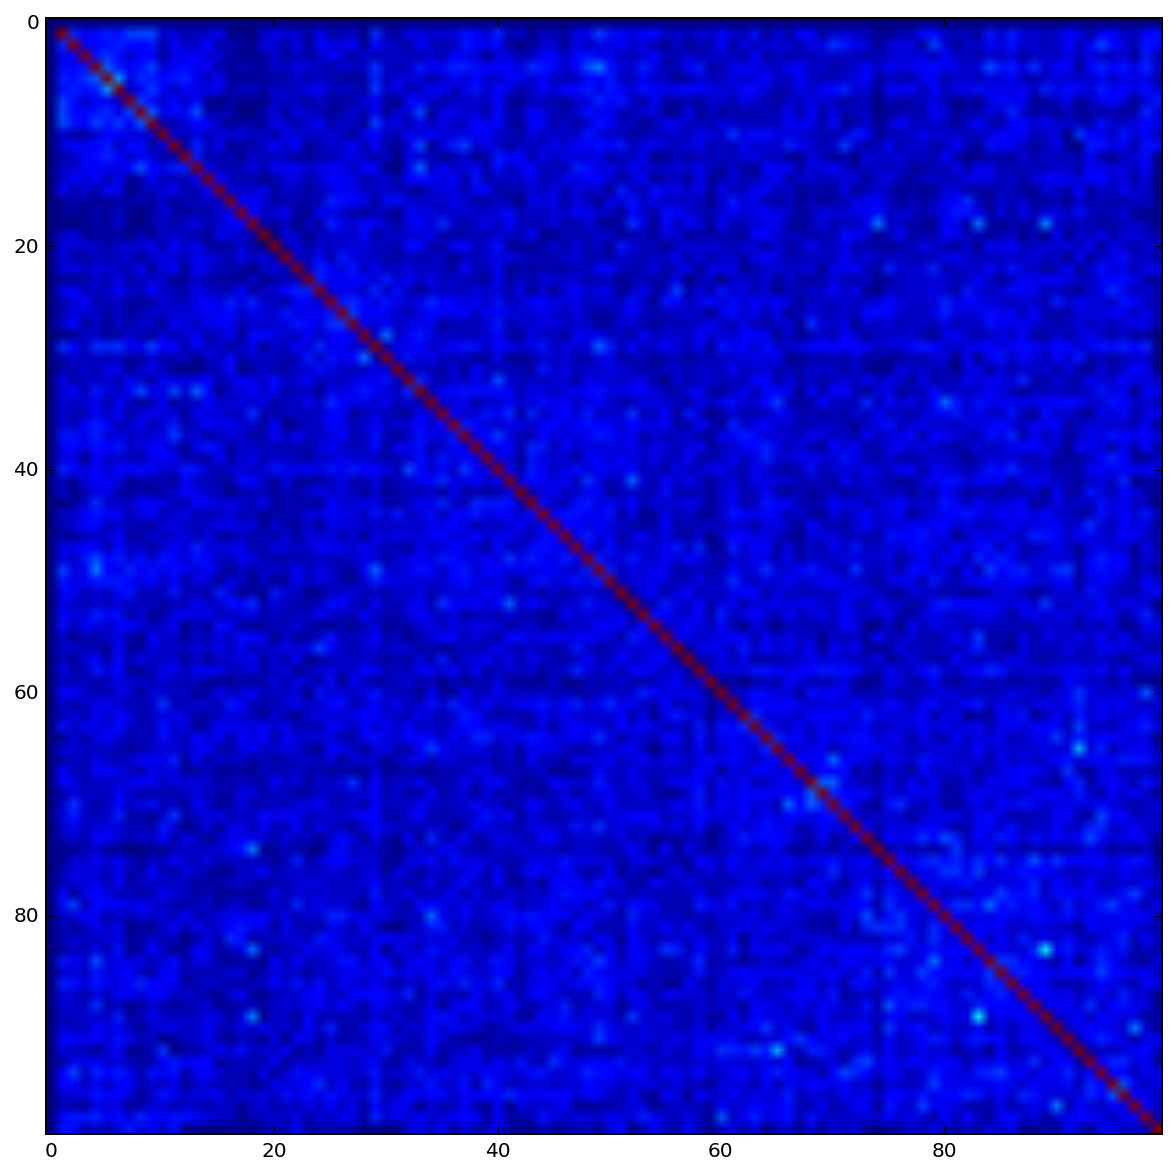

In [9]:
# I didn't find anything interesting in terms of term coincidence,
# but here's the code anyways.
all_posters = [];
direct = '/Users/Torben/cns_posters/'
posts = 100; #909
score_mat = np.zeros((posts,posts))

for fi in xrange(posts):
    f = open(direct + 'Poster'+str(fi),"r")
    
    all_posters.append(clean_bag_o_words(f.read()));

for p1 in xrange(1,posts):
    for p2 in xrange(1,posts):
        score_mat[p1,p2] = simpleCount(all_posters[p1],all_posters[p2])
figure(figsize=(10,10))
plt.imshow(score_mat)

(array([ 122.,   47.,   27.,   75.,   77.,   88.,   95.,   69.,   61.,
          55.,   61.,   47.,   36.,   40.,   33.,   17.,    9.,    5.,
          11.,    7.,    2.,    4.,    0.,    0.,    1.,    0.,    2.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    9.]),
 array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
         0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
         0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.2

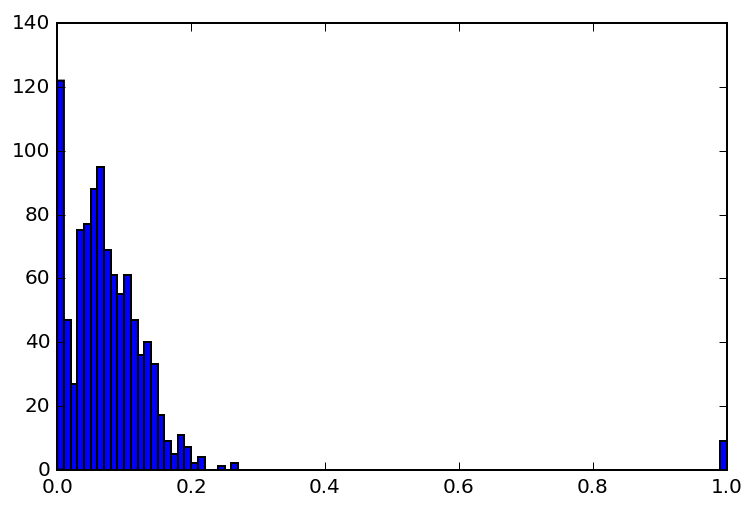

In [23]:
score_mat_resize = resize(score_mat, [1000,1])
plt.hist(score_mat_resize,100)

(912, 3407)


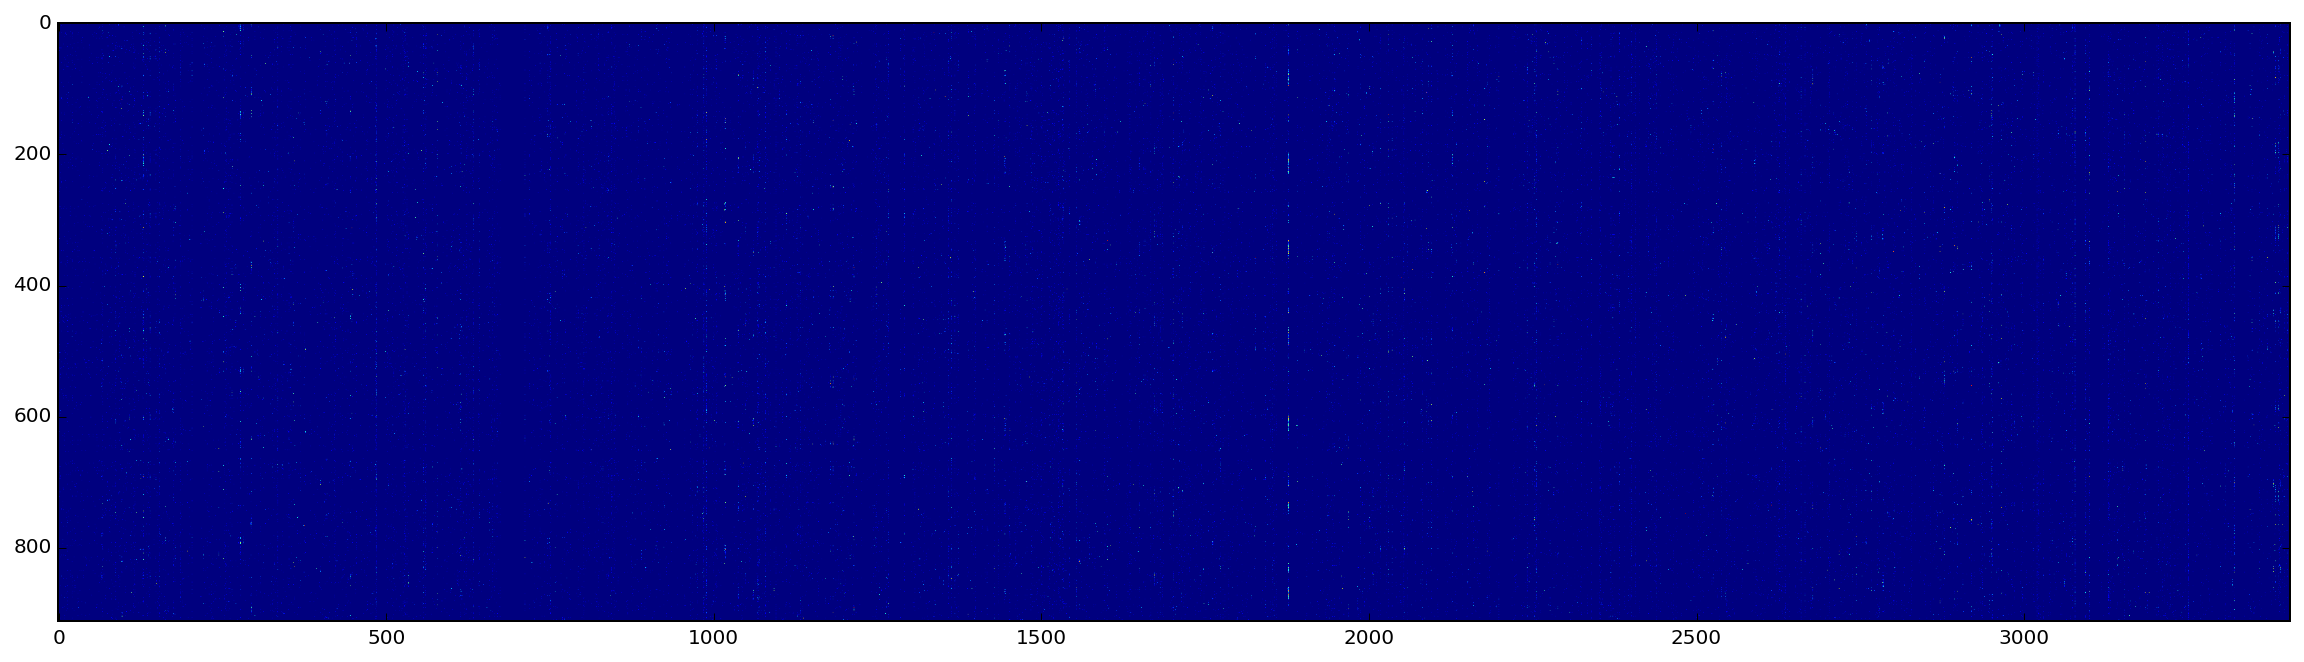

In [7]:
# spm is included as sparse_poster_matrix.np in this repo

spm = sparse_poster_mat(labels,posts=912)
print spm.shape
plt.figure(figsize=(20,20))
plt.imshow(spm)

In [45]:
# Warnings are expected. Some terms have no matches. 
# Some posters are all zeros due to weird cleaning issues.
model = lda.LDA(n_topics=15, n_iter=1500, random_state=1)
model.fit(spm.astype(int64))

<lda.lda.LDA instance at 0x112745fc8>

In [46]:
topic_word = model.topic_word_
n_top_words = 11
for i, topic_dist in enumerate(topic_word):
     topic_words = np.array(labels)[np.argsort(topic_dist)][:-n_top_words:-1]
     print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: STIMULATION MOTOR ALPHA THETA EEG POWER PHASE ACTION OSCILLATIONS HZ
Topic 1: LANGUAGE SENTENCES ENGLISH SENTENCE COMPREHENSION READING BILINGUALS HEMISPHERE NATIVE SPEAKERS
Topic 2: ERP ERPS EFFECT EFFECTS RESPONSE AMPLITUDE POTENTIALS CONDITION LARGER EARLY
Topic 3: MEMORY RETRIEVAL ENCODING WORKING EPISODIC RECOGNITION HIPPOCAMPUS HIPPOCAMPAL INFORMATION WM
Topic 4: COGNITIVE TASK ET AL USING TASKS NEUROSCIENCE PERFORMANCE RESEARCH INDIVIDUAL
Topic 5: TASK INFORMATION REWARD CONTROL RESPONSE COGNITIVE CUES TRIALS MODEL PREDICTION
Topic 6: LEARNING TRAINING SLEEP LEARNED GROUP NOVEL SESSION PERFORMANCE TEST NEW
Topic 7: ADULTS AGE OLDER CHILDREN PERFORMANCE YOUNG FUNCTION YEARS DEVELOPMENT ABILITY
Topic 8: VISUAL ATTENTION STIMULI LOCATION OBJECTS SPATIAL OBJECT PRESENTED TARGET REPRESENTATIONS
Topic 9: EMOTIONAL EMOTION STRESS NEUTRAL NEGATIVE STIMULI ANXIETY AFFECTIVE COGNITIVE POSITIVE
Topic 10: NETWORK CONNECTIVITY FRONTAL NETWORKS GYRUS PREFRONTAL INFERIOR ANTERIOR TEMP

In [9]:
# most frequent labels found using sum of all appearances in all posters
print [labels[i] for i in reversed(argsort(sum(spm,0)))][0:25]
print [i for i in reversed(np.sort(sum(spm,0)))][0:25]

['MEMORY', 'TASK', 'COGNITIVE', 'VISUAL', 'EFFECTS', 'STIMULI', 'USING', 'PERFORMANCE', 'ADULTS', 'INFORMATION', 'EFFECT', 'LEARNING', 'CONTROL', 'WORDS', 'RESPONSE', 'ATTENTION', 'LANGUAGE', 'SUGGEST', 'NETWORK', 'TEMPORAL', 'GROUP', 'WORD', 'TIME', 'EMOTIONAL', 'CONNECTIVITY']
[1189.0, 850.0, 710.0, 582.0, 470.0, 458.0, 437.0, 433.0, 406.0, 393.0, 390.0, 387.0, 378.0, 361.0, 359.0, 354.0, 341.0, 340.0, 326.0, 323.0, 309.0, 300.0, 292.0, 289.0, 280.0]


In [50]:
# abstract shaming
direct = '/Users/Torben/cns_posters/'
f = open(direct + 'Poster'+str(833),"r");
print f.read()

G51
CHANGES  IN  GLOBAL  AND  REGIONAL  MODULARITY  ASSOCIATED WITH INCREASING WORKING MEMORY LOAD Matthew  Stanley1, Dale  Dagenbach1, Robert  Lyday1, Jonathan  Burdette1, Paul  Laurienti1; 1Wake 
Forest University — The recent use of graph theory measures in complex network analyses of neuroimaging data has allowed for the identiﬁ cation and 
classiﬁ cation  of  global  and  regional  brain  network  properties  as  well  as 
the ability to quantify changes in network properties across different task 
conditions. We investigated the effects of increasing working memory processing load on functional brain network modularity in a cohort of young 
adults. Measures of modularity in complex brain networks quantify how 
well  a  network  is  organized  into  densely  interconnected  communities. 
We investigated changes in both the large-scale modular organization of 
the functional brain network as a whole and regional changes in modular 
organization as demands on working memory increase

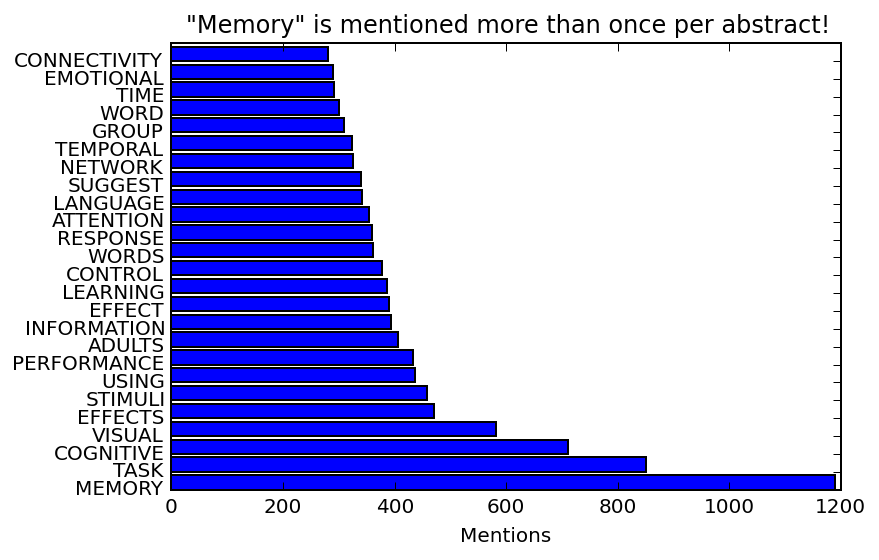

In [23]:
# making term frequency plot
labs = ['MEMORY', 'TASK', 'COGNITIVE', 'VISUAL', 'EFFECTS', 'STIMULI', 'USING', 'PERFORMANCE', 'ADULTS', 'INFORMATION', 'EFFECT', 'LEARNING', 'CONTROL', 'WORDS', 'RESPONSE', 'ATTENTION', 'LANGUAGE', 'SUGGEST', 'NETWORK', 'TEMPORAL', 'GROUP', 'WORD', 'TIME', 'EMOTIONAL', 'CONNECTIVITY']
scores = [1189.0, 850.0, 710.0, 582.0, 470.0, 458.0, 437.0, 433.0, 406.0, 393.0, 390.0, 387.0, 378.0, 361.0, 359.0, 354.0, 341.0, 340.0, 326.0, 323.0, 309.0, 300.0, 292.0, 289.0, 280.0]
print len(scores)
x_pos = np.arange(len(labs))
plt.barh(x_pos,scores)
yticks(x_pos,labs)
xlabel('Mentions')
title('"Memory" is mentioned more than once per abstract!')

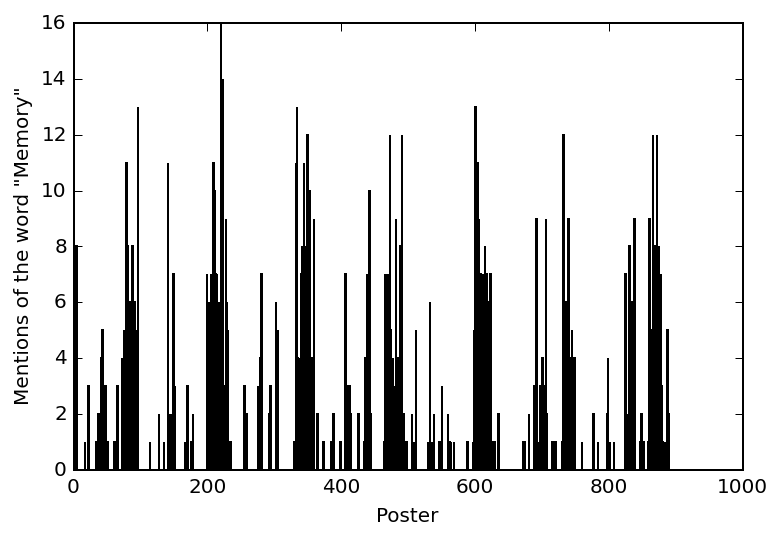

In [36]:
# memory frequency plot
plt.bar(np.arange(912),spm[:,1877]) #1877 is ind of memory in term database
ylabel('Mentions of the word "Memory"')
xlabel('Poster')

[ 0.17350993  0.0013245   0.0013245   0.0013245   0.38543046  0.02781457
  0.0410596   0.0013245   0.0013245   0.01456954  0.05430464  0.0013245
  0.0410596   0.02781457  0.22649007]


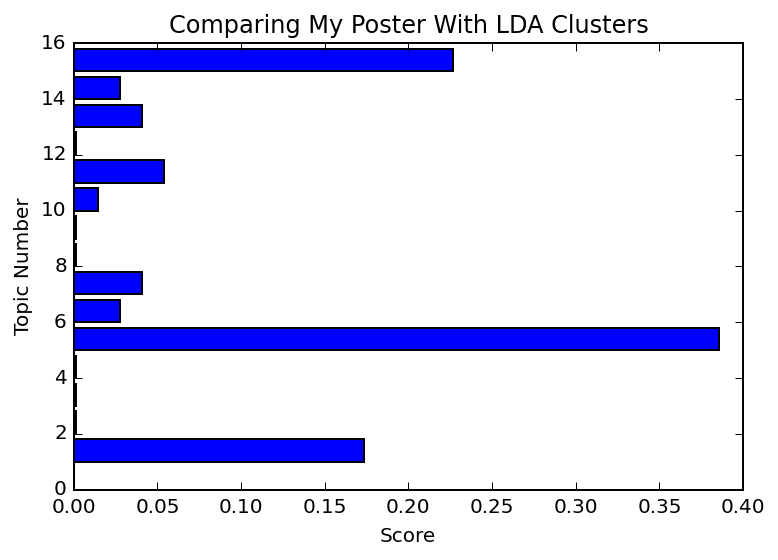

In [65]:
# Comparing my poster to clusters
print model.doc_topic_[883]
plt.barh(np.arange(1,16),model.doc_topic_[883])
ylabel('Topic Number')
xlabel('Score')
title('Comparing My Poster With LDA Clusters')

In [12]:
direct = '/Users/Torben/Documents/terms'
np.save(direct,labels)